# RNN

## Lib and Data Loading

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    confusion_matrix,
    roc_auc_score,
    average_precision_score,
    RocCurveDisplay,
    PrecisionRecallDisplay,
    ConfusionMatrixDisplay
)
import torch
import torch.nn as nn
import pytorch_lightning as pl
from torch.utils.data import DataLoader, TensorDataset
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor, ModelCheckpoint
import torchmetrics

import os
from glob import glob
from pathlib import Path
from tqdm.notebook import tqdm
import ipywidgets as widgets
from IPython.display import display, clear_output
from matplotlib import pyplot as plt

# override all pandas display limits
pd.options.display.max_columns = None
pd.options.display.max_rows = None



In [2]:
# load parquet files
data_path = Path("../../../data")
notebooks_path = Path(os.getcwd())
data_dir = {}

##unsafe
# for file_path in list((notebooks_path / data_path).glob("*.parquet")):
#     print(f"Reading {file_path}")
#     # retrieve the name of the file without the extension for all OS
#     data = pd.read_parquet(file_path)
#     # if "Time" in df.columns:
#     #     df["Time"] = pd.to_datetime(df["Time"])
#     data_dir[str(file_path).replace("\\", "/").split("/")[-1].split(".")[0].replace("-", "_")] = data

for file_path in (notebooks_path / data_path).glob("set*.parquet"):
    var_name = file_path.stem.replace("-", "_")
    globals()[var_name] = pd.read_parquet(file_path)
    print(f"Reading {file_path} -> {var_name}")


ID_vars = ["PatientID", "Time", "RecordID"]
# stationary variables
stationary_vars = ["Age", "Gender", "Height", "ICUType"]
# dynamic variables
dynamic_vars = set_a.columns.difference(stationary_vars + ID_vars).tolist()


Reading /home/pbaertschi/ICU-TimeSeries-Mortality-Prediction/notebooks/2_SupervisedML/Q2_RNN/../../../data/set-a-filled.parquet -> set_a_filled
Reading /home/pbaertschi/ICU-TimeSeries-Mortality-Prediction/notebooks/2_SupervisedML/Q2_RNN/../../../data/set-b.parquet -> set_b
Reading /home/pbaertschi/ICU-TimeSeries-Mortality-Prediction/notebooks/2_SupervisedML/Q2_RNN/../../../data/set-a.parquet -> set_a
Reading /home/pbaertschi/ICU-TimeSeries-Mortality-Prediction/notebooks/2_SupervisedML/Q2_RNN/../../../data/set-c-filled.parquet -> set_c_filled
Reading /home/pbaertschi/ICU-TimeSeries-Mortality-Prediction/notebooks/2_SupervisedML/Q2_RNN/../../../data/set-c.parquet -> set_c
Reading /home/pbaertschi/ICU-TimeSeries-Mortality-Prediction/notebooks/2_SupervisedML/Q2_RNN/../../../data/set-b-filled.parquet -> set_b_filled


## Preprocess Data Shape

In [3]:
class TimeSeriesDataModule(pl.LightningDataModule):
    def __init__(
        self,
        feature_cols,
        batch_size=32
    ):
        super().__init__()
        self.feature_cols = feature_cols
        self.batch_size = batch_size

    def preprocess_parquet_for_lstm(self, key):
        labelname = 'In-hospital_death'
        df = globals()[f"set_{key}_filled"].copy()
    
        # Group by patient
        X = []
        y = []
        for pid, group in df.groupby("RecordID"):
            group = group.sort_values("Time")
            group.fillna(0, inplace=True)
    
            X.append(group[self.feature_cols].values)
            # Take the label from the first row (same for all timepoints)
            y.append(group[labelname].iloc[0])
    
        X_tensor = torch.tensor(np.stack(X)).float()  # (n_patients, seq_len, n_features)
        y_tensor = torch.tensor(y).float()            # (n_patients,)
    
        return X_tensor, y_tensor


    def setup(self, stage=None):
        self.X_train, self.y_train = self.preprocess_parquet_for_lstm("a")
        self.X_val, self.y_val     = self.preprocess_parquet_for_lstm("b")
        self.X_test, self.y_test   = self.preprocess_parquet_for_lstm("c")

        self.train_dataset = TensorDataset(self.X_train, self.y_train)
        self.val_dataset   = TensorDataset(self.X_val, self.y_val)
        self.test_dataset  = TensorDataset(self.X_test, self.y_test)

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size)



## LSTM Model Class

In [4]:
class LSTMClassifier(pl.LightningModule):
    def __init__(self, input_size, hidden_size=64, num_layers=1, lr=1e-3):
        super().__init__()
        self.save_hyperparameters()
        self.lr = lr

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.classifier = nn.Linear(hidden_size, 1)
        self.loss_fn = nn.BCEWithLogitsLoss()

        # Store test outputs manually
        self.test_probs = []
        self.test_targets = []

        # Prediction threshold
        self.prediction_threshold = 0.5
        self.clear_after_testing = False

    def forward(self, x):
        # Run input through the LSTM
        _, (hidden_state, _) = self.lstm(x)  # lstm_output, (hidden_state, cell_state)

        # Take the last layer's hidden state (for stacked LSTM)
        last_hidden = hidden_state[-1]  # shape: (batch_size, hidden_dim)

        # Pass through the classification head
        logits = self.classifier(last_hidden)

        return logits

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x).squeeze(1)
        loss = self.loss_fn(logits, y.float())
        self.log("train_loss", loss, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x).squeeze(1)
        loss = self.loss_fn(logits, y.float())
        preds = torch.sigmoid(logits) > 0.5
        acc = (preds.int() == y).float().mean()
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", acc, prog_bar=True)
        return loss
        

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x).squeeze(1)
        probs = torch.sigmoid(logits)
        loss = self.loss_fn(logits, y.float())

        self.log("test_loss", loss)

        # Store results for epoch-end metrics
        self.test_probs.append(probs.detach().cpu())
        self.test_targets.append(y.detach().cpu())

        return loss  # or None — you’re not using batch outputs anymore

    def on_test_epoch_end(self):
            probs = torch.cat(self.test_probs).cpu()
            targets = torch.cat(self.test_targets).cpu()
            preds = (probs > 0.5).int()

            if self.clear_after_testing: 
                self.test_probs.clear()
                self.test_targets.clear()
    
            # --- Confusion Matrix ---
            cm = confusion_matrix(targets, preds)
            disp_cm = ConfusionMatrixDisplay(confusion_matrix=cm)
            disp_cm.plot(cmap='Blues')
            plt.title("Confusion Matrix")
            plt.show()
    
            # --- ROC Curve ---
            auc = roc_auc_score(targets, probs)
            RocCurveDisplay.from_predictions(targets, probs)
            plt.title(f"ROC Curve (AuROC = {auc:.3f})")
            plt.show()
    
            # --- Precision-Recall Curve ---
            auprc = average_precision_score(targets, probs)
            PrecisionRecallDisplay.from_predictions(targets, probs)
            plt.title(f"Precision-Recall Curve (AuPRC = {auprc:.3f})")
            plt.show()
    
            # --- Metrics ---
            acc = (preds == targets).float().mean()
            self.log("test_acc", acc)
            self.log("test_auroc", auc)
            self.log("test_auprc", auprc)
    
            print(f"\nTest Accuracy : {acc:.4f}")
            print(f"Test AuROC    : {auc:.4f}")
            print(f"Test AuPRC    : {auprc:.4f}")


    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        scheduler = {
            'scheduler': torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5, verbose=True),
            'monitor': 'val_loss',
            'interval': 'epoch',
            'frequency': 1
        }
        return {"optimizer": optimizer, "lr_scheduler": scheduler}

    def tune_threshold_min_fnr(self):
        """
        Find the classification threshold that minimizes the False Negative Rate (FNR)
        and store it in self.prediction_threshold.
    
        Returns:
            best_thresh (float): Threshold with the lowest FNR
            best_fnr (float): Lowest observed FNR
            thresholds (np.ndarray): Array of tested thresholds
            fnrs (List[float]): FNRs corresponding to each threshold
        """
    
        assert hasattr(self, "test_probs") and hasattr(self, "test_targets"), \
            "test_probs and test_targets must be defined (run test first)."
    
        probs = torch.cat(self.test_probs).cpu().numpy()
        targets = torch.cat(self.test_targets).cpu().numpy()
    
        thresholds = np.linspace(0, 1, 100)
        best_thresh = 0.5
        best_fnr = 1.0
        fnrs = []
    
        for t in tqdm(thresholds):
            preds = (probs >= t).astype(int)
            tn, fp, fn, tp = confusion_matrix(targets, preds).ravel()
            fnr = fn / (fn + tp) if (fn + tp) > 0 else 1.0
            fnrs.append(fnr)
    
            if fnr < best_fnr:
                best_fnr = fnr
                best_thresh = t
    
        self.prediction_threshold = best_thresh
    
        return best_thresh, best_fnr, thresholds, fnrs

In [5]:
# Callbacks for trainer
early_stop_callback = EarlyStopping(monitor='val_loss', patience=10, verbose=True, mode='min')
lr_monitor = LearningRateMonitor(logging_interval='epoch')
checkpoint_callback = ModelCheckpoint(monitor='val_loss', mode='min', save_top_k=1, verbose=True, filename='best-checkpoint')

# Instantiate
feature_cols = dynamic_vars + stationary_vars
datamodule = TimeSeriesDataModule(feature_cols=feature_cols, batch_size=64)
model = LSTMClassifier(input_size=len(feature_cols), hidden_size=64, num_layers=2)

# Trainer
trainer = pl.Trainer(
    max_epochs=20,
    callbacks=[early_stop_callback, lr_monitor, checkpoint_callback],
    log_every_n_steps=10,
    accelerator="auto",
    devices="auto"
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


## Training

In [9]:
# Fit
trainer.fit(model, datamodule=datamodule)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type              | Params | Mode 
---------------------------------------------------------
0 | lstm       | LSTM              | 60.9 K | train
1 | classifier | Linear            | 65     | train
2 | loss_fn    | BCEWithLogitsLoss | 0      | train
---------------------------------------------------------
61.0 K    Trainable params
0         Non-trainable params
61.0 K    Total params
0.244     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved. New best score: 0.388
Epoch 0, global step 63: 'val_loss' reached 0.38838 (best 0.38838), saving model to '/home/pbaertschi/ICU-TimeSeries-Mortality-Prediction/notebooks/2_SupervisedML/Q2_RNN/lightning_logs/version_12330/checkpoints/best-checkpoint.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.024 >= min_delta = 0.0. New best score: 0.364
Epoch 1, global step 126: 'val_loss' reached 0.36420 (best 0.36420), saving model to '/home/pbaertschi/ICU-TimeSeries-Mortality-Prediction/notebooks/2_SupervisedML/Q2_RNN/lightning_logs/version_12330/checkpoints/best-checkpoint.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.358
Epoch 2, global step 189: 'val_loss' reached 0.35808 (best 0.35808), saving model to '/home/pbaertschi/ICU-TimeSeries-Mortality-Prediction/notebooks/2_SupervisedML/Q2_RNN/lightning_logs/version_12330/checkpoints/best-checkpoint.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 252: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.356
Epoch 4, global step 315: 'val_loss' reached 0.35568 (best 0.35568), saving model to '/home/pbaertschi/ICU-TimeSeries-Mortality-Prediction/notebooks/2_SupervisedML/Q2_RNN/lightning_logs/version_12330/checkpoints/best-checkpoint.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5, global step 378: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6, global step 441: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7, global step 504: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 0.345
Epoch 8, global step 567: 'val_loss' reached 0.34475 (best 0.34475), saving model to '/home/pbaertschi/ICU-TimeSeries-Mortality-Prediction/notebooks/2_SupervisedML/Q2_RNN/lightning_logs/version_12330/checkpoints/best-checkpoint.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 9, global step 630: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 10, global step 693: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.345
Epoch 11, global step 756: 'val_loss' reached 0.34462 (best 0.34462), saving model to '/home/pbaertschi/ICU-TimeSeries-Mortality-Prediction/notebooks/2_SupervisedML/Q2_RNN/lightning_logs/version_12330/checkpoints/best-checkpoint.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.338
Epoch 12, global step 819: 'val_loss' reached 0.33793 (best 0.33793), saving model to '/home/pbaertschi/ICU-TimeSeries-Mortality-Prediction/notebooks/2_SupervisedML/Q2_RNN/lightning_logs/version_12330/checkpoints/best-checkpoint.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 0.330
Epoch 13, global step 882: 'val_loss' reached 0.33005 (best 0.33005), saving model to '/home/pbaertschi/ICU-TimeSeries-Mortality-Prediction/notebooks/2_SupervisedML/Q2_RNN/lightning_logs/version_12330/checkpoints/best-checkpoint.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 14, global step 945: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 15, global step 1008: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.327
Epoch 16, global step 1071: 'val_loss' reached 0.32674 (best 0.32674), saving model to '/home/pbaertschi/ICU-TimeSeries-Mortality-Prediction/notebooks/2_SupervisedML/Q2_RNN/lightning_logs/version_12330/checkpoints/best-checkpoint.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.325
Epoch 17, global step 1134: 'val_loss' reached 0.32545 (best 0.32545), saving model to '/home/pbaertschi/ICU-TimeSeries-Mortality-Prediction/notebooks/2_SupervisedML/Q2_RNN/lightning_logs/version_12330/checkpoints/best-checkpoint.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 18, global step 1197: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.318
Epoch 19, global step 1260: 'val_loss' reached 0.31810 (best 0.31810), saving model to '/home/pbaertschi/ICU-TimeSeries-Mortality-Prediction/notebooks/2_SupervisedML/Q2_RNN/lightning_logs/version_12330/checkpoints/best-checkpoint.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=20` reached.


## Testing

['lightning_logs/version_12330/checkpoints/best-checkpoint.ckpt']
lightning_logs/version_12330/checkpoints/best-checkpoint.ckpt


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Testing: |          | 0/? [00:00<?, ?it/s]

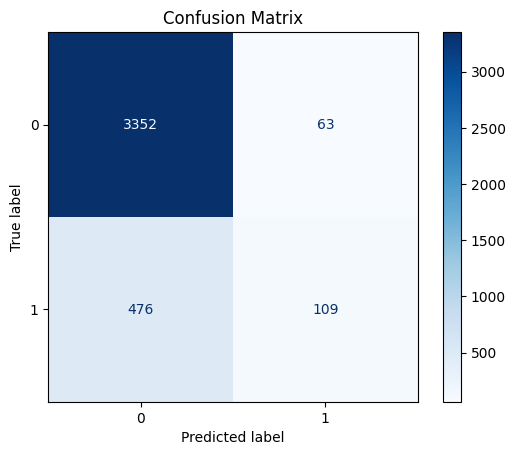

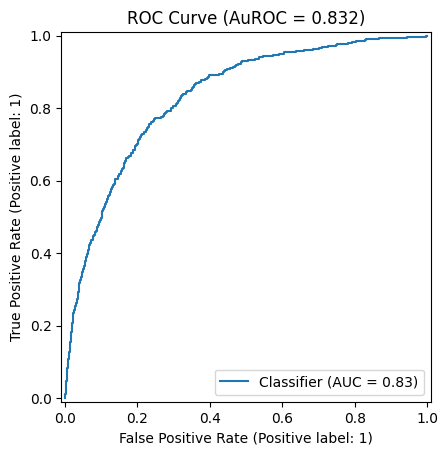

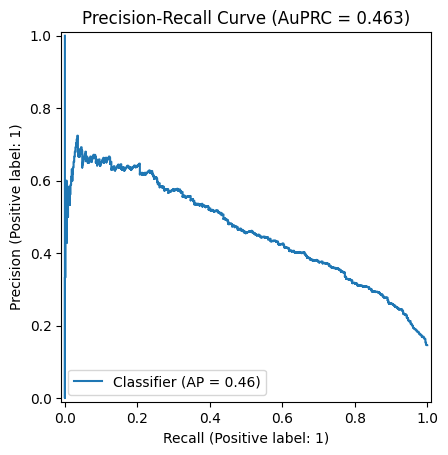


Test Accuracy : 0.8652
Test AuROC    : 0.8316
Test AuPRC    : 0.4631


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8652499914169312     │
│        test_auprc         │    0.4630735218524933     │
│        test_auroc         │    0.8315866589546204     │
│         test_loss         │    0.3274860680103302     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.3274860680103302,
  'test_acc': 0.8652499914169312,
  'test_auroc': 0.8315866589546204,
  'test_auprc': 0.4630735218524933}]

In [10]:
log_root = "lightning_logs" # ICU-TimeSeries-Mortality-Prediction/notebooks/2_SupervisedML/Q2_RNN/lightning_logs"
manual_version = None # "12302"
latest_version = max(os.listdir(log_root), key=lambda x: int(x.split("_")[1]) if x.split("_")[0] == "version" else 0)
latest_ckpt_dir = os.path.join(log_root, manual_version) if manual_version else os.path.join(log_root, latest_version)
# print(latest_ckpt_dir)

# Get path to best .ckpt file
ckpt_files = glob(os.path.join(latest_ckpt_dir, "checkpoints", "*.ckpt"))
best_ckpt_path = ckpt_files[0] if ckpt_files else None
print(best_ckpt_path)

model = LSTMClassifier.load_from_checkpoint(best_ckpt_path)
trainer.test(model, datamodule=datamodule)

## Optimize decision Threshold

  0%|          | 0/100 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Minimize FNR at Threshold')

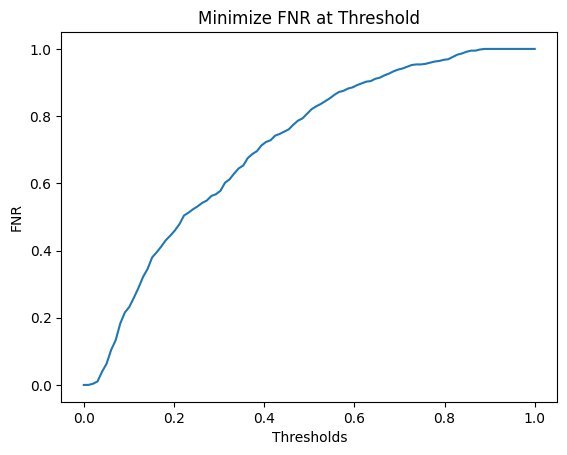

In [11]:
# idea: minimize threshold
_, _, thresholds, fnrs = model.tune_threshold_min_fnr()
plt.plot(thresholds, fnrs)
plt.xlabel("Thresholds")
plt.ylabel("FNR")
plt.title("Minimize FNR at Threshold")
# outcome: to simplistic approach, converges to 0

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Testing: |          | 0/? [00:00<?, ?it/s]

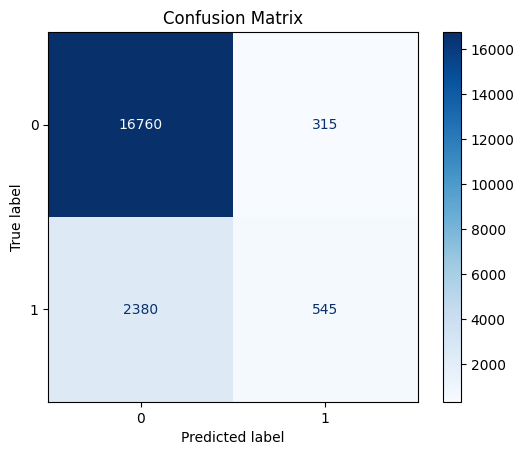

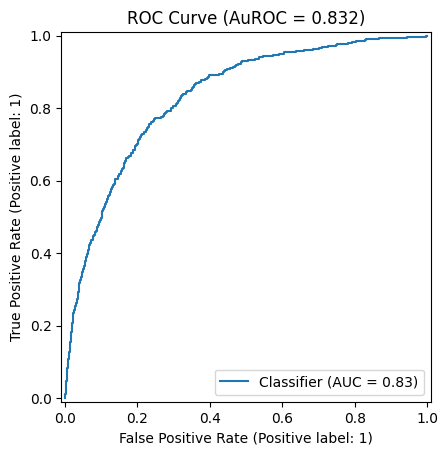

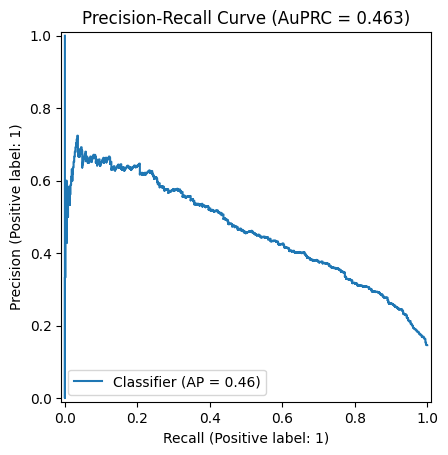


Test Accuracy : 0.8652
Test AuROC    : 0.8316
Test AuPRC    : 0.4631


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8652499914169312     │
│        test_auprc         │    0.4630735218524933     │
│        test_auroc         │    0.8315866589546204     │
│         test_loss         │    0.3274860680103302     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.3274860680103302,
  'test_acc': 0.8652499914169312,
  'test_auroc': 0.8315866589546204,
  'test_auprc': 0.4630735218524933}]

In [18]:
model.prediction_threshold = 0.65
trainer.test(model, datamodule = datamodule)